# Gene expression variability
### Analysis of Variance (ANOVA) using different approaches

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

In [33]:
df = pd.read_csv('genetherapy.csv')

In [5]:
df.head()

,expr,Therapy
0,100,A
1,96,A
2,101,A
3,95,A
4,103,A


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   expr     60 non-null     int64 
 1   Therapy  60 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


Text(0, 0.5, 'Gene expression')

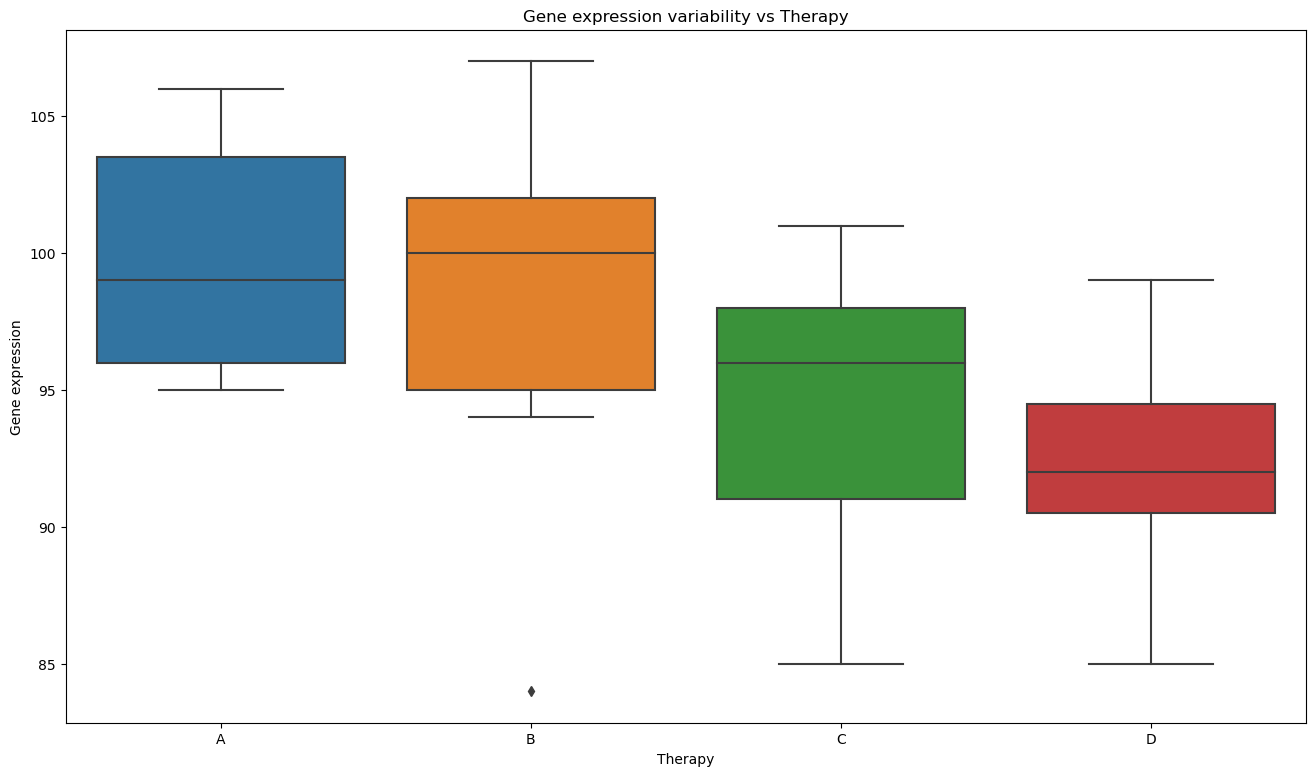

In [7]:
plt.figure(figsize=(16, 9))
sns.boxplot(x='Therapy', y='expr', data=df)

plt.title('Gene expression variability vs Therapy')
plt.xlabel('Therapy')
plt.ylabel('Gene expression')

In [34]:
therapy_A = df[df['Therapy'] == 'A']['expr']
therapy_B = df[df['Therapy'] == 'B']['expr']
therapy_C = df[df['Therapy'] == 'C']['expr']
therapy_D = df[df['Therapy'] == 'D']['expr']

### Perform Levene's test

Levene's test assesses whether the variances across different groups are equal

Interpretation

- Null Hypothesis (H₀): The variances are equal across the groups.
- Alternative Hypothesis (H₁): The variances are not equal across the groups.

In [36]:
from scipy.stats import levene

stat, p_value = levene(therapy_A, therapy_B, therapy_C, therapy_D)

print(f"Levene's test statistic: {stat}")
print(f"P-value: {p_value}")

if p_value > 0.05:
    print("\nFail to reject the null hypothesis. The variances are equal.")
else:
    print("\nReject the null hypothesis. The variances are not equal.")

Levene's test statistic: 0.6477908627745761
P-value: 0.5876330665111003

Fail to reject the null hypothesis. The variances are equal.


### Create Q-Q plots for each group and check for normality

This setup allows us to visually inspect the normality of each group's distribution. If the data points fall along the line, the distribution is approximately normal. Deviations from this line indicate departures from normality.

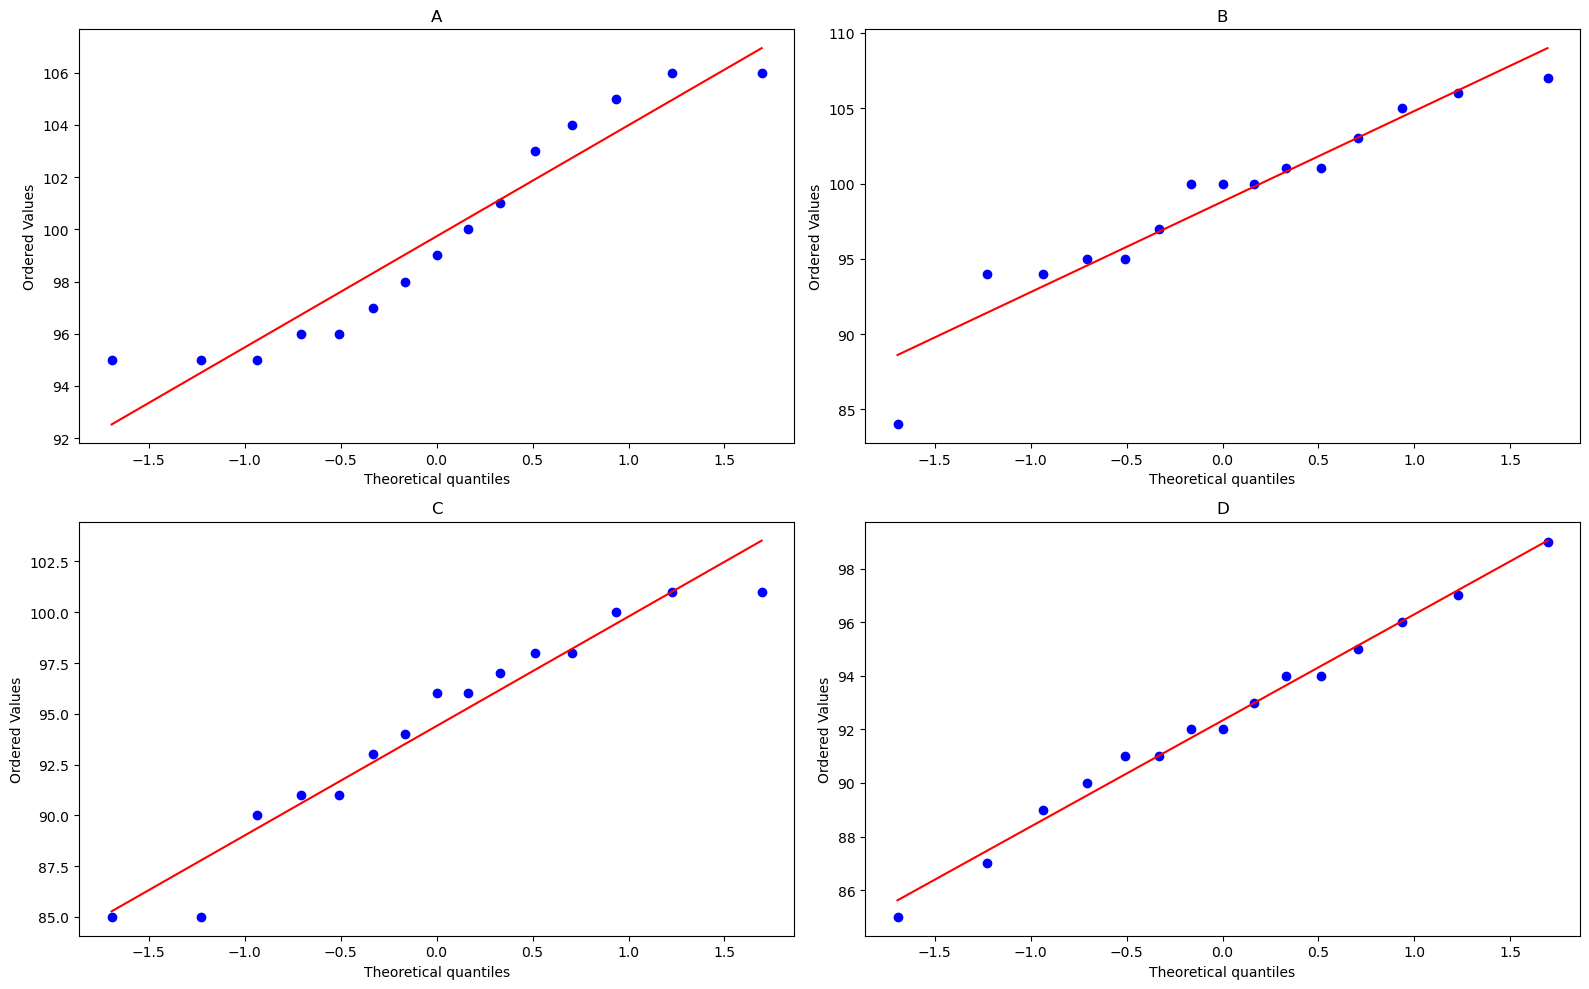

In [37]:
from scipy.stats import probplot

groups = [therapy_A, therapy_B, therapy_C, therapy_D]
group_labels = ['A', 'B', 'C', 'D']

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for i, (group, label) in enumerate(zip(groups, group_labels)):
    row = i // 2
    col = i % 2
    probplot(group, dist="norm", plot=axes[row, col])
    axes[row, col].set_title(label)

plt.tight_layout()
plt.show()

### Perform ANOVA (manual approach)

In [38]:
therapy_list = df['Therapy'].unique()

In [19]:
# Number of groups and total number of observations

k = len(therapy_list)
n = len(df)

# Calculate group means and overall mean

group_means = [df[df['Therapy'] == therapy]['expr'].mean() for therapy in therapy_list]
overall_mean = df['expr'].mean()

# Calculate the between-group sum of squares (SSB)

SSB = sum(len(df[df['Therapy'] == therapy]['expr']) * (group_mean - overall_mean) ** 2 for therapy, group_mean in zip(therapy_list, group_means))

# Calculate the within-group sum of squares (SSW)

SSW = sum(sum((df[df['Therapy'] == therapy]['expr'] - group_mean) ** 2) for therapy, group_mean in zip(therapy_list, group_means))

# Calculate degrees of freedom

DFB = k - 1  # Between-group degrees of freedom
DFW = n - k  # Within-group degrees of freedom

# Calculate mean squares

MSB = SSB / DFB
MSW = SSW / DFW

# Calculate the F-statistic

F_statistic = MSB / MSW

# Calculate the p-value

p_value = stats.f.sf(F_statistic, DFB, DFW)

In [20]:
print(f"F-statistic: {F_statistic:.3f}")
print(f"P-value: {p_value:.5f}")

alpha = 0.05

if p_value < alpha:
    print("\nReject the null hypothesis: There is a significant difference between the therapies.")
else:
    print("\nFail to reject the null hypothesis: There is no significant difference between the therapies.")

F-statistic: 8.037
P-value: 0.00015

Reject the null hypothesis: There is a significant difference between the therapies.


### Perform ANOVA using 'scipy.stats.f_oneway'

In [11]:
from scipy.stats import f_oneway

F_statistic, p_value = f_oneway(therapy_A, therapy_B, therapy_C, therapy_D)

print(f"F-statistic: {F_statistic}")
print(f"P-value: {p_value}")

if p_value < alpha:
    print("\nReject the null hypothesis: There is a significant difference between the therapies.")
else:
    print("\nFail to reject the null hypothesis: There is no significant difference between the therapies.")

F-statistic: 8.03730248114399
P-value: 0.00015249722895229536

Reject the null hypothesis: There is a significant difference between the therapies.


### Perform ANOVA using 'statsmodels'

In [12]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

model = ols('expr ~ Therapy', data=df).fit()
anova_results = anova_lm(model)

print(anova_results)

            df       sum_sq     mean_sq         F    PR(>F)
Therapy    3.0   560.716667  186.905556  8.037302  0.000152
Residual  56.0  1302.266667   23.254762       NaN       NaN


### Plot means with confidence interval lines

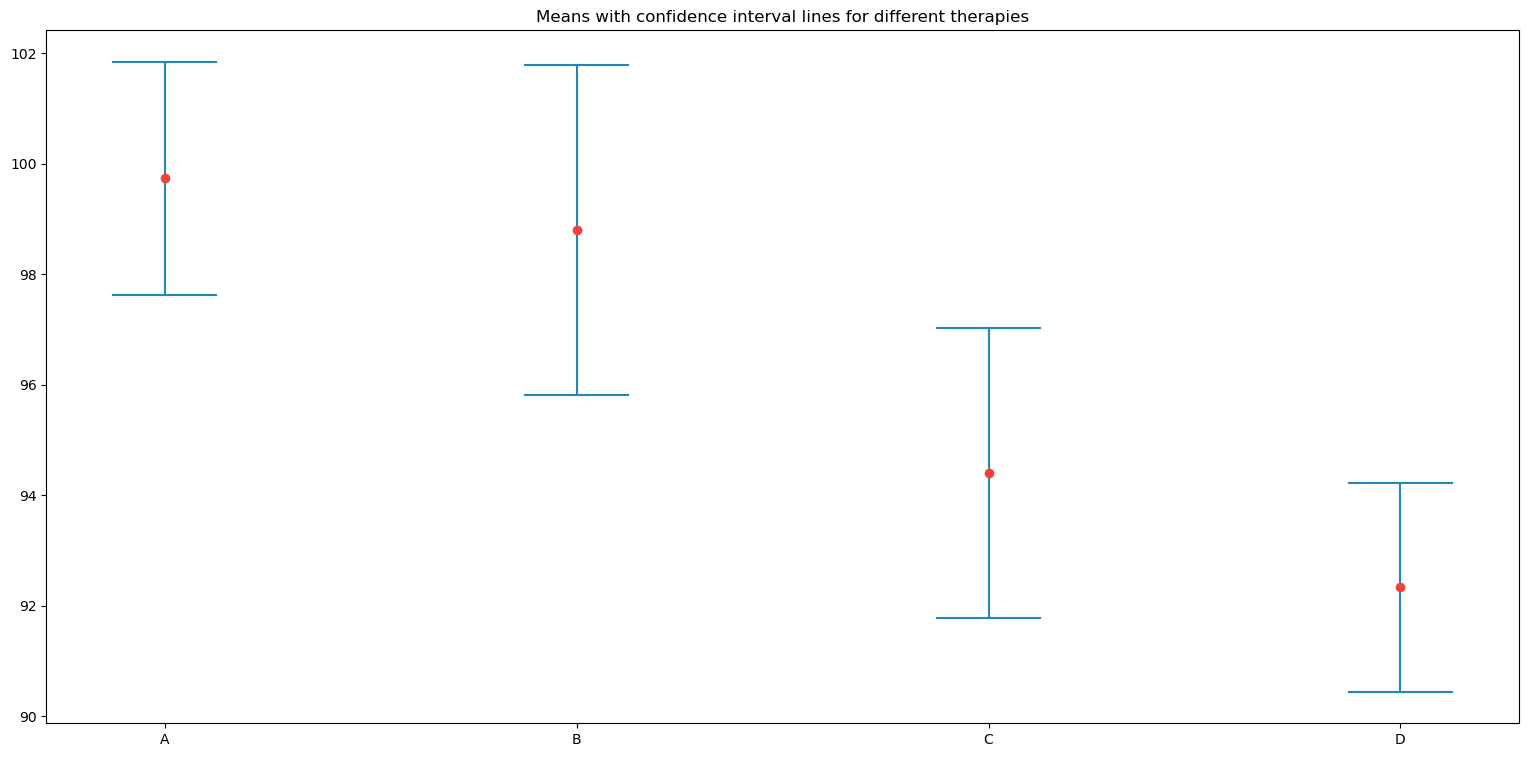

In [21]:
import statistics
from math import sqrt

def plot_confidence_interval(x, values, z=1.96, color='#2187bb', horizontal_line_width=0.25):
    mean = statistics.mean(values)
    stdev = statistics.stdev(values)
    confidence_interval = z * stdev / sqrt(len(values))

    left = x - horizontal_line_width / 2
    top = mean - confidence_interval
    right = x + horizontal_line_width / 2
    bottom = mean + confidence_interval

    # Plot confidence interval lines
    plt.plot([x, x], [top, bottom], color=color)  # Vertical line for CI
    plt.plot([left, right], [top, top], color=color)  # Top horizontal line
    plt.plot([left, right], [bottom, bottom], color=color)  # Bottom horizontal line
    plt.plot(x, mean, 'o', color='#f44336')  # Mean point

    return mean, confidence_interval

plt.figure(figsize=(19, 9))
plt.xticks([1, 2, 3, 4], ['A', 'B', 'C', 'D'])
plt.title('Means with confidence interval lines for different therapies')

plot_confidence_interval(1, therapy_A)
plot_confidence_interval(2, therapy_B)
plot_confidence_interval(3, therapy_C)
plot_confidence_interval(4, therapy_D)

plt.show()

The plot of means with confidence intervals supports our hypothesis that the differences in therapies are statistically significant

### Perform Tukey's HSD test

In [26]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=df['expr'], groups=df['Therapy'], alpha=0.05)
print("\nTukey's HSD Results for all therapy pairs:\n")
print(tukey)


Tukey's HSD Results for all therapy pairs:

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     A      B  -0.9333 0.9514  -5.5959  3.7292  False
     A      C  -5.3333 0.0189  -9.9959 -0.6708   True
     A      D     -7.4 0.0005 -12.0626 -2.7374   True
     B      C     -4.4  0.071  -9.0626  0.2626  False
     B      D  -6.4667 0.0029 -11.1292 -1.8041   True
     C      D  -2.0667 0.6458  -6.7292  2.5959  False
-----------------------------------------------------


### Conclusion

---

- We got that all different approaches of using analysis of variance showed identical results, which tells us that we did everything right when we calculated the f-statistic and p-value manually.

- Using Tukey's HSD test, we found out which pairs of the therapies used have statistically significant differences between them (A-C, A-D, B-D) 